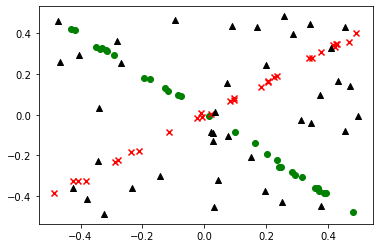

Total number of generated points: 100


In [1]:
#######################################
## Line Clustering - synthetic dataset with 2 lines + noise (3 groups)
#######################################

## STEP 1: GENERATE POINTS with 2 lines + noise

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(27)

# Generate points along a line 
def y(x, m, b):
    return m*x + b 

# 2 lines containing 30 points each 
X_1=[np.random.uniform(-0.5,0.5) for _ in range(30)]
X_2=[np.random.uniform(-0.5,0.5) for _ in range(30)]
y_1 = [y(x, -1, 0) + np.random.normal(0,0.01) for x in X_1]
y_2 = [y(x, 0.8, 0) + np.random.normal(0,0.01) for x in X_2]

# add 40 points of noise  
x=[np.random.uniform(-0.5,0.5) for _ in range(40)]
y=[np.random.uniform(-0.5,0.5) for _ in range(40)]

# plot the result
plt.scatter(X_1, y_1, c='g')
plt.scatter(X_2, y_2, c='r',marker='x')
plt.scatter(x,y, c='black',marker='^')
#plt.savefig('2lines.png', dpi=300, bbox_inches='tight')
plt.show()

# Group the points
Xtot= np.concatenate((X_1,X_2,x))
Ytot= np.concatenate((y_1,y_2,y))
points = np.column_stack((Xtot,Ytot))

nb_points = len(points)
print("Total number of generated points: " + str(nb_points))

# TRUE NODE LABELS - put the noise in a label numbered 0 
trueZ = [1]*30 + [2]*30 +[0]*40


In [2]:
## STEP 2: CREATE HYPEREDGES OF SIZE 3
import math 
np.random.seed(4)

sigma2= 0.02**2
hyperedges_size3 = []

# SIMPLE HYPERGRAPH (in the following while loop, we insert constraints to avoid both multiset of nodes and multi hyperedges)

while len(hyperedges_size3) < 20000: 
    index = np.random.choice(range(nb_points),3,replace=False).tolist() # avoid multisets with replace=False

    A = points[index]
    x = A[:, 0]
    y = A[:, 1]
    fit = np.polyfit(x, y, deg=1, full=True)   #find residuals: are these 3 points aligned?
    d = fit[1]
    if math.exp(-d**2/sigma2) > 0.999:
        index.sort()
        if index not in hyperedges_size3:   # CONSTRAINT: avoid multiplicity of the same hyperedge
            hyperedges_size3.append(index)

len(hyperedges_size3)      # here we have 20 000 different hyperedges of size 3

20000

In [3]:
# CREATE .TXT FILE WITH ALL PREVIOUSLY CREATED HYPEREDGES OF SIZE 3
with open('hypergraph_3uniform_2lines.txt', 'w') as f:
    separator = ','
    for item in hyperedges_size3:
        # When we write the file, we encode hyperedges from node 1 to node n
        item = [x+1 for x in item]
        string = map(str, item)
        line = separator.join(string) 
        f.writelines(line+'\n')

In [4]:
# Imports and auxiliary functions 

import os

## Function: hyperedge of nodes from the same cluster line?
## This is used to set the signal:noise-hyperedge ratio
def lineEdge(e):
    s = set([trueZ[i] for i in e])  
    return (len(s)==1 and 0 not in s) # exclude group 0 as it is noise group


In [5]:
# Sampling of REP hypergraphs 

## Expected proportion of "signal" (same line) vs "noise" hyperedges is 2:1.
mu = 0.33 ## proportion of noisy hyperedges among all to keep

np.random.seed(27)
REP = 100    #number of hypergraphs that we generate

os.mkdir("data_2linecluster/")
   
nb_hyperedges =[]

for rep in range(REP): 
    
    ## We start from our list of hyperedges - contains 20 000 hyperedges
    x = [lineEdge(i) for i in hyperedges_size3]
    f = x.count(False) # original list has 13 232 noise-hyperedges
    ## Sample down true cases 
    ptrue = 0.1
    htrue = [hyperedges_size3[i] for i in range(len(hyperedges_size3)) if x[i] and np.random.sample()<ptrue]
    t = len(htrue) # number of true hyperedges

    ## Sample down False cases to get ratio mu of noise-hyperedges               
    pfalse = mu*t/((1-mu)*f)
    hfalse = [hyperedges_size3[i] for i in range(len(hyperedges_size3)) if (not x[i]) and np.random.sample()<pfalse]
    h = htrue+hfalse
    nb_hyperedges.append(len(h))
    # resulting sampled hypergraphs has approx 1000 hyperedges 
    
    # Identify possibly isolated nodes ? 
    unique_nodes = set()
    for e in h:
        unique_nodes.update(e)
    isolated = set(range(nb_points)).difference(unique_nodes)    
    trueZ_rep= [trueZ[i] for i in unique_nodes]
    #nb_nodes = len(unique_nodes)
    #nb_isolates = nb_points - nb_nodes
    
    # Write down this hypergraph to analyse it with HyperSBM and with Chodrow's method
    dirname = "data_2linecluster/rep_" + str(rep) +"/"
    os.makedirs(dirname)
    filename = str(dirname) +"hyperedges.txt"
    with open(filename, "w") as fichier:
        for edge in h: 
            fichier.write(str(','.join(str(x+1) for x in edge)) + "\n") # we add +1 to count from 1 to n
    
    filename = str(dirname) +"isolated.txt"
    with open(filename, "w") as fichier:
        for node in isolated: 
            fichier.write(str(node) + "\n") 
    
    filename = str(dirname) +"true_clusters.txt"
    with open(filename, "w") as fichier:
        for cluster in trueZ_rep: 
            fichier.write(str(cluster) + "\n") 

# end of generation 



FileExistsError: [Errno 17] File exists: 'data_2linecluster/'

In [6]:
print(np.mean(nb_hyperedges))

NameError: name 'nb_hyperedges' is not defined